# Testing Elliptical Dataset

Need to confirm theory.

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import simulate, simulate_or_load, make_key
from localization.utils import plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort, build_DRT, normal_adjust, uniform_adjust, no_adjust
from scipy.special import erf

gaussian_pdf = lambda x, mu, sigma: (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)
gaussian_cdf = lambda x: 0.5 * (erf(x/np.sqrt(2)) + 1)

def Z(g):
    return jnp.sqrt( (2/jnp.pi) * jnp.arcsin( (2*g**2) / (1 + (2*g**2)) ) )

In [2]:
config = dict(
  # data config
  num_dimensions=200,
  # xi=(3, 3),
  # xi=(0.1, 0.1),
  xi=(15, 15),
  adjust=(-1, 1),
  gain=0.5, #100,
  key=jax.random.PRNGKey(0),
)

dataset = datasets.EllipticalDataset(inverse_cdf=lambda x: -0.5 * jnp.log(2/((x-2)+1) - 1), **config)
x = dataset[:500][0]

## Training weights

File EllipticalDataset[-1.00,01.00]_xi1=03.00_xi2=01.00_p=0.50_batch_size=1000_num_epochs=1500_loss=mse_lr=0.100_SimpleNet-1_L=040_K=001_activation=sigmoid_init_scale=0.100_xavier_normal_init.npz not found
Simulating
Using JAX backend: cpu

Using configuration:
{'activation': 'sigmoid',
 'adjust': (-1, 1),
 'base_dataset': <class 'localization.datasets.nonlinear_gp.NonlinearGPDataset'>,
 'batch_size': 1000,
 'bias_trainable': False,
 'bias_value': -1,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.elliptical.EllipticalDataset'>,
 'df': None,
 'dim': 1,
 'evaluation_interval': 10,
 'gain': None,
 'init_fn': <function xavier_normal_init at 0x15bba3380>,
 'init_scale': 0.1,
 'kwargs': {'scale': 2},
 'learning_rate': 0.1,
 'marginal_adjust': <function <lambda> at 0x15de14c20>,
 'model_cls': <class 'localization.models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1500,
 'num_hiddens': 1,
 'num_steps': 1000,
 'optimizer_fn': <function sgd at 0x13cde

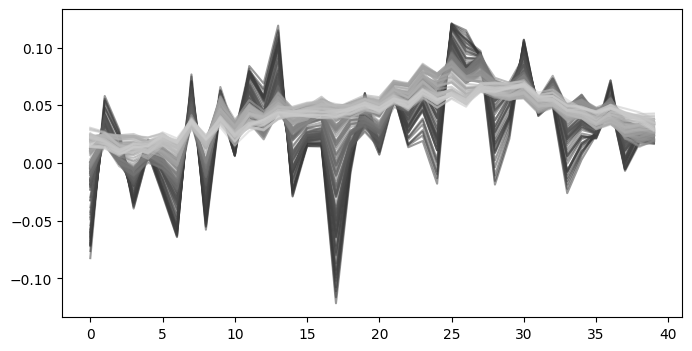

In [25]:
config = dict(
  # data config
  num_dimensions=40,
  xi=(1, 3),
  adjust=(-1, 1),
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  # activation='relu', use_bias=False, batch_size=10000, init_scale=0.01, learning_rate=0.1, evaluation_interval=50,
  activation='sigmoid', use_bias=True, bias_value=-1, bias_trainable=False, batch_size=1000, init_scale=0.1, learning_rate=0.1, evaluation_interval=10,
  num_hiddens=1,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  optimizer_fn=optax.sgd,
  num_epochs=1500,
  # experiment config
  seed=42,#0,
  save_=True,
)

DRT = build_DRT(config['num_dimensions'])
num_epochs = config['num_epochs']
lr = config['learning_rate']

# weights_gauss, metrics_gauss = simulate_or_load(**config, gain=100, dataset_cls=datasets.NLGPGaussianCloneDataset)
# _ = plot_rf_evolution(weights_gauss[-10:], figsize=(8, 4))

weights_nlgp, metrics_nlgp = simulate_or_load(**config, scale=2, dataset_cls=datasets.EllipticalDataset)
_ = plot_rf_evolution(weights_nlgp[:,:1], figsize=(8, 4))

As expected!

(251, 1, 100)


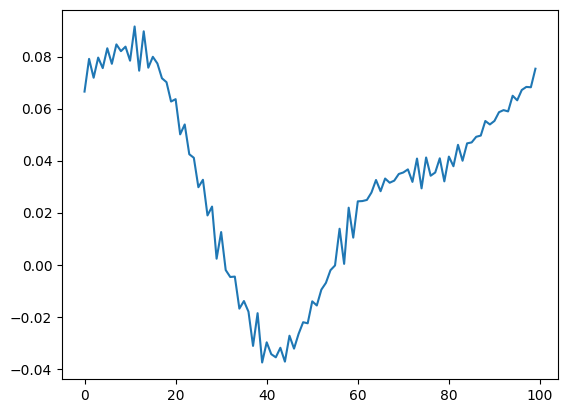

In [22]:
print(weights_nlgp.shape)
_ = plt.plot(weights_nlgp[-1,0])

#### Breaking radial symmetry

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import simulate, simulate_or_load, make_key
from localization.utils import plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort, build_DRT, normal_adjust, uniform_adjust, no_adjust
from scipy.special import erf

gaussian_pdf = lambda x, mu, sigma: (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)
gaussian_cdf = lambda x: 0.5 * (erf(x/np.sqrt(2)) + 1)

def Z(g):
    return jnp.sqrt( (2/jnp.pi) * jnp.arcsin( (2*g**2) / (1 + (2*g**2)) ) )

In [2]:
config = dict(
  # data config
  num_dimensions=100,
  xi=(3, 5),
  adjust=(-1, 1),
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  activation='relu', use_bias=False, batch_size=5000, init_scale=0.01, learning_rate=0.1, evaluation_interval=50,
  # activation='sigmoid', use_bias=True, bias_value=-1, bias_trainable=False, batch_size=1000, init_scale=0.1, learning_rate=0.1, evaluation_interval=10,
  num_hiddens=1,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  optimizer_fn=optax.sgd,
  num_epochs=1500,
  # experiment config
  seed=42,#0,
  save_=True,
)

def break_fn(x):
  return jnp.any(jnp.abs(x) < 0.1)

DRT = build_DRT(config['num_dimensions'])
num_epochs = config['num_epochs']
lr = config['learning_rate']

# weights_nlgp, metrics_nlgp = simulate_or_load(**config, dataset_cls=datasets.NonlinearGPDataset, gain=100)
# weights_nlgp, metrics_nlgp = simulate_or_load(**config, dataset_cls=datasets.EllipticalDataset)
weights_nlgp, metrics_nlgp = simulate_or_load(**config, scale=2, dataset_cls=datasets.SymmBreakDataset, base_dataset=datasets.EllipticalDataset, break_fn=break_fn)
_ = plot_rf_evolution(weights_nlgp[:,:1], figsize=(8, 4))

File SymmBreakDataset_EllipticalDataset[-1.00,01.00]_xi1=05.00_xi2=03.00_p=0.50_batch_size=5000_num_epochs=1500_loss=mse_lr=0.100_SimpleNetnobias_L=100_K=001_activation=relu_init_scale=0.010_xavier_normal_init.npz not found
Simulating
Using JAX backend: cpu

Using configuration:
{'activation': 'relu',
 'adjust': (-1, 1),
 'base_dataset': <class 'localization.datasets.elliptical.EllipticalDataset'>,
 'batch_size': 5000,
 'bias_trainable': True,
 'bias_value': 0.0,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.symmbreak.SymmBreakDataset'>,
 'df': None,
 'dim': 1,
 'evaluation_interval': 50,
 'gain': None,
 'init_fn': <function xavier_normal_init at 0x15d594720>,
 'init_scale': 0.01,
 'kwargs': {'break_fn': <function break_fn at 0x15f889da0>, 'scale': 2},
 'learning_rate': 0.1,
 'marginal_adjust': <function <lambda> at 0x15f889080>,
 'model_cls': <class 'localization.models.feedforward.SimpleNet'>,
 'num_dimensions': 100,
 'num_epochs': 1500,
 'num_hiddens': 1,
 

ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (2 of them) had size 5000, e.g. axis 0 of argument x of type float32[5000,100];
  * one axis had size 1: axis 0 of argument key of type uint32[1,2]

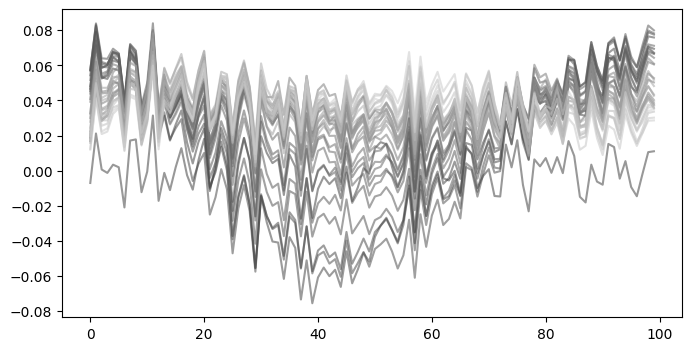

In [6]:
_ = plot_rf_evolution(weights_nlgp[:,:1], figsize=(8, 4))